# Regression & Classification Model Implementation

In [274]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LinearRegression
from scipy import stats
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error, mean_absolute_error, confusion_matrix, roc_curve, auc
from sklearn.utils import resample
from sklearn import datasets, linear_model
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor 

In [301]:
# Helper functions

def VIF(df, columns): 
    values=sm.add_constant(df[columns]).values
    # the dataframe passed to VIF␣ ↪ must include the intercept term. We add it the same way we did before. 
    num_columns=len(columns)+1#we added intercept 
    vif=[variance_inflation_factor(values, i) for i in range(num_columns)] 
    return pd.Series(vif[1:], index=columns)

def OSR2(model, y_train, x_test,y_test):
    y_pred=model.predict(x_test) 
    SSE=np.sum((y_test-y_pred)**2) 
    SST=np.sum((y_test-np.mean(y_train))**2) 
    return 1-(SSE/SST)

def avg_error(y_pred, y_test):
    return np.average(abs((y_pred - y_test) / y_test))

def get_metrics(y_predict, y_test):
    cm = confusion_matrix(y_test, y_predict)
    tn, fn, fp, tp = cm[0][0], cm[1][0], cm[0][1], cm[1][1]
    FPR = fp / (fp + tn)
    TPR = tp / (tp + fn)
    acc = (tp + tn) / (tp + tn + fp + fn)
    PRE = 0
    if (tp + fp != 0):
        PRE = tp / (tp + fp)
    return acc, TPR, FPR, PRE

def bootstrap(test_data, test_label, model, metric, sample=500, random_state=66):
    n_sample = sample
    output_array=[]
    for bs_iter in range(n_sample):
        bs_index = np.random.choice(test_data.index, len(test_data.index), replace=True)
        bs_data = test_data.loc[bs_index]
        bs_label = test_label.loc[bs_index]
        bs_predicted = model.predict(bs_data)
        output_array.append(metric(bs_predicted,bs_label))
    output_series = pd.Series(output_array)
    return output_series

## Load Data - Train & Test split with time benchmark

In [276]:
training_data = pd.read_csv('../features_train.csv')
training_data.drop(columns=['Unnamed: 0'], inplace=True)
training_data = training_data.drop(0)
training_data['Previous Sentiment'] = training_data['Sentiment'].shift(1)
training_data = training_data[1:]

testing_data = pd.read_csv('../features_test.csv')
testing_data.drop(columns=['Unnamed: 0'], inplace=True)
testing_data['Previous Sentiment'] = testing_data['Sentiment'].shift(1)

testing_data = testing_data[1:]
X_train = training_data.drop(columns=['Tesla Stock Close Price'])
y_train = training_data['Tesla Stock Close Price']
X_test = testing_data.drop(columns=['Tesla Stock Close Price'])
y_test = testing_data['Tesla Stock Close Price']

#use only the important features
features =X_train.columns
X_train.head()

,Tesla Stock Open Price,Tesla Stock Volume,Tesla Stock Adj Close Price,Tesla Stock High,Tesla Stock Low,S&P 500 Variance,Ford Stock Price,GM Stock Price,Toyota Stock Price,Nissan Stock Price,Tesla Wikipedia Page Views,Sentiment,Previous Sentiment,Previous Week Tesla Stock Close Price
2,1.401200,13199100.0,1.388933,1.424133,1.354267,435.732436,13.0400,34.189999,72.763998,15.460,1102.2,0.140323,0.089603,1.384800
3,1.256267,12649800.0,1.232667,1.264800,1.215600,380.825787,12.5600,34.189999,70.756001,15.062,898.0,0.040080,0.140323,1.388933
4,1.255867,7230300.0,1.261200,1.282000,1.233067,316.106150,12.0020,34.189999,70.690001,15.200,801.0,0.188023,0.040080,1.232667
5,1.303333,8167800.0,1.312267,1.333600,1.282933,591.345328,11.3280,34.189999,69.030000,14.992,766.2,0.168206,0.188023,1.261200
6,1.357833,6225000.0,1.385000,1.403833,1.351167,615.993610,11.7975,34.189999,69.000000,15.745,808.5,0.119400,0.168206,1.312267


## Linear Regression & Feature Engineering

In [277]:
#Now we want to see how the model behaves. We train the linear regression.
#We will mostly focus on the p-values, the VIF values, and R2.
X=X_train
Y=y_train
X2 = sm.add_constant(X)
lrm=sm.OLS(Y, X2).fit()
print(lrm.summary())
print(VIF(training_data, features))

pd.set_option('display.max_colwidth', None) 

                               OLS Regression Results                              
Dep. Variable:     Tesla Stock Close Price   R-squared:                       1.000
Model:                                 OLS   Adj. R-squared:                  1.000
Method:                      Least Squares   F-statistic:                 1.079e+20
Date:                     Sun, 05 May 2024   Prob (F-statistic):               0.00
Time:                             17:17:27   Log-Likelihood:                 7723.3
No. Observations:                      431   AIC:                        -1.542e+04
Df Residuals:                          416   BIC:                        -1.536e+04
Df Model:                               14                                         
Covariance Type:                 nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------

In [278]:
#We see that the p-values are very high for some features, we should eliminate them.
#We eliminate Tesla's Financial Features which are very correlated with the Close Price we are trying to predict, since it has a very high p-value as well as a high VIF value.
X_train = X_train.drop(columns=['Tesla Stock Open Price','Tesla Stock Adj Close Price','Tesla Stock High', 'Tesla Stock Low'])
X=X_train
X2=sm.add_constant(X)
lrm=sm.OLS(Y, X2).fit()
print(lrm.summary())
print(VIF(training_data, X_train.columns))

                               OLS Regression Results                              
Dep. Variable:     Tesla Stock Close Price   R-squared:                       0.989
Model:                                 OLS   Adj. R-squared:                  0.989
Method:                      Least Squares   F-statistic:                     3759.
Date:                     Sun, 05 May 2024   Prob (F-statistic):               0.00
Time:                             17:17:27   Log-Likelihood:                -515.49
No. Observations:                      431   AIC:                             1053.
Df Residuals:                          420   BIC:                             1098.
Df Model:                               10                                         
Covariance Type:                 nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------

In [279]:
#Now we eliminate Nissan stock prices, since it has a very high p-value
X_train = X_train.drop(columns=['Nissan Stock Price'])
X=X_train
X2=sm.add_constant(X)
lrm=sm.OLS(Y, X2).fit()
print(lrm.summary())
print(VIF(training_data, X_train.columns))

                               OLS Regression Results                              
Dep. Variable:     Tesla Stock Close Price   R-squared:                       0.989
Model:                                 OLS   Adj. R-squared:                  0.989
Method:                      Least Squares   F-statistic:                     4187.
Date:                     Sun, 05 May 2024   Prob (F-statistic):               0.00
Time:                             17:17:27   Log-Likelihood:                -515.49
No. Observations:                      431   AIC:                             1051.
Df Residuals:                          421   BIC:                             1092.
Df Model:                                9                                         
Covariance Type:                 nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------

In [280]:
#Now we eliminate  SP500 Variance , since it has a very high p-value
X_train = X_train.drop(columns=['S&P 500 Variance'])
X=X_train
X2=sm.add_constant(X)
lrm=sm.OLS(Y, X2).fit()
print(lrm.summary())
print(VIF(training_data, X_train.columns))

                               OLS Regression Results                              
Dep. Variable:     Tesla Stock Close Price   R-squared:                       0.989
Model:                                 OLS   Adj. R-squared:                  0.989
Method:                      Least Squares   F-statistic:                     4721.
Date:                     Sun, 05 May 2024   Prob (F-statistic):               0.00
Time:                             17:17:27   Log-Likelihood:                -515.51
No. Observations:                      431   AIC:                             1049.
Df Residuals:                          422   BIC:                             1086.
Df Model:                                8                                         
Covariance Type:                 nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------

In [281]:
#Now we eliminate Tesla Wikipedia Page Views, since it has a very high p-value
X_train = X_train.drop(columns=['Tesla Wikipedia Page Views'])
X=X_train
X2=sm.add_constant(X)
lrm=sm.OLS(Y, X2).fit()
print(lrm.summary())
print(VIF(training_data, X_train.columns))

                               OLS Regression Results                              
Dep. Variable:     Tesla Stock Close Price   R-squared:                       0.989
Model:                                 OLS   Adj. R-squared:                  0.989
Method:                      Least Squares   F-statistic:                     5407.
Date:                     Sun, 05 May 2024   Prob (F-statistic):               0.00
Time:                             17:17:27   Log-Likelihood:                -515.58
No. Observations:                      431   AIC:                             1047.
Df Residuals:                          423   BIC:                             1080.
Df Model:                                7                                         
Covariance Type:                 nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------

In [282]:
#Now we eliminate Volume, since it has a very high p-value
X_train = X_train.drop(columns=['Tesla Stock Volume'])
X=X_train
X2=sm.add_constant(X)
lrm=sm.OLS(Y, X2).fit()
print(lrm.summary())
print(VIF(training_data, X_train.columns))

                               OLS Regression Results                              
Dep. Variable:     Tesla Stock Close Price   R-squared:                       0.989
Model:                                 OLS   Adj. R-squared:                  0.989
Method:                      Least Squares   F-statistic:                     6307.
Date:                     Sun, 05 May 2024   Prob (F-statistic):               0.00
Time:                             17:17:28   Log-Likelihood:                -516.09
No. Observations:                      431   AIC:                             1046.
Df Residuals:                          424   BIC:                             1075.
Df Model:                                6                                         
Covariance Type:                 nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------

In [283]:
#Now we eliminate Sentiment scores, since it has a very high p-value
X_train = X_train.drop(columns=['Sentiment'])
X=X_train
X2=sm.add_constant(X)
lrm=sm.OLS(Y, X2).fit()
print(lrm.summary())
print(VIF(training_data, X_train.columns))

                               OLS Regression Results                              
Dep. Variable:     Tesla Stock Close Price   R-squared:                       0.989
Model:                                 OLS   Adj. R-squared:                  0.989
Method:                      Least Squares   F-statistic:                     7570.
Date:                     Sun, 05 May 2024   Prob (F-statistic):               0.00
Time:                             17:17:28   Log-Likelihood:                -516.56
No. Observations:                      431   AIC:                             1045.
Df Residuals:                          425   BIC:                             1070.
Df Model:                                5                                         
Covariance Type:                 nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------

In [284]:
#Now we eliminate GM stock prices, since it has a very high p-value
X_train = X_train.drop(columns=['GM Stock Price'])
X=X_train
X2=sm.add_constant(X)
lrm=sm.OLS(Y, X2).fit()
print(lrm.summary())
print(VIF(training_data, X_train.columns))

                               OLS Regression Results                              
Dep. Variable:     Tesla Stock Close Price   R-squared:                       0.989
Model:                                 OLS   Adj. R-squared:                  0.989
Method:                      Least Squares   F-statistic:                     9443.
Date:                     Sun, 05 May 2024   Prob (F-statistic):               0.00
Time:                             17:17:28   Log-Likelihood:                -517.49
No. Observations:                      431   AIC:                             1045.
Df Residuals:                          426   BIC:                             1065.
Df Model:                                4                                         
Covariance Type:                 nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------

In [285]:
#Now we eliminate Ford stock prices, since it has a very high p-value
X_train = X_train.drop(columns=['Ford Stock Price'])
X=X_train
X2=sm.add_constant(X)
lrm=sm.OLS(Y, X2).fit()
print(lrm.summary())
print(VIF(training_data, X_train.columns))

                               OLS Regression Results                              
Dep. Variable:     Tesla Stock Close Price   R-squared:                       0.989
Model:                                 OLS   Adj. R-squared:                  0.989
Method:                      Least Squares   F-statistic:                 1.259e+04
Date:                     Sun, 05 May 2024   Prob (F-statistic):               0.00
Time:                             17:17:29   Log-Likelihood:                -518.06
No. Observations:                      431   AIC:                             1044.
Df Residuals:                          427   BIC:                             1060.
Df Model:                                3                                         
Covariance Type:                 nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------

(63, 14)
R2 Score: 0.9725787708603995
OSR2 Score: 0.9922626917883026
Mean Absolute Error: 10.098887378382408
Mean Absolute Error Percentage: 0.07143988072713697


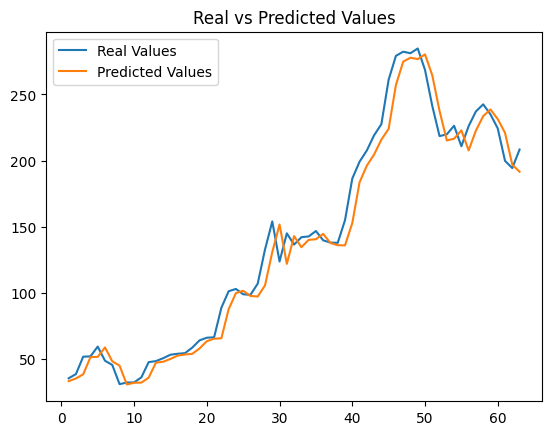

In [286]:
from sklearn.metrics import r2_score

print(X_test.shape)
X_test = X_test.drop(columns=['Tesla Stock Open Price','Tesla Stock Volume','Tesla Stock Adj Close Price','Tesla Stock High','Tesla Stock Low','S&P 500 Variance', 'Tesla Wikipedia Page Views','Nissan Stock Price','Sentiment','Ford Stock Price','GM Stock Price'])
X_test=sm.add_constant(X_test)

y_pred = lrm.predict(X_test)

# Assuming y_test and y_pred are the actual and predicted values, respectively
r2 = r2_score(y_test, y_pred)
print("R2 Score:", r2)

osr2=OSR2(lrm, y_train, X_test, y_test)
print("OSR2 Score:", osr2)

mean_absolute_error = np.mean(np.abs(y_test - y_pred))
mean_absolute_error_percentage = mean_absolute_error / np.mean(y_test)
print("Mean Absolute Error:", mean_absolute_error)
print("Mean Absolute Error Percentage:", mean_absolute_error_percentage)

variance_mae_percentage = np.var(bootstrap(X_test, y_test, lrm, avg_error))

plt.title('Real vs Predicted Values')

plt.plot(y_test,  label= 'Real Values')
plt.plot(y_pred, label = 'Predicted Values')
plt.legend()
plt.show()

## Load Data - Train & Test random split

#### Random split is needed for accuracy of tree-based models since the range of possible stock price values changes over time

In [287]:
tesla_data = pd.read_csv('../full-tesla-data.csv')
tesla_data.drop(columns=['Unnamed: 0'], inplace=True)
tesla_data['Previous Sentiment'] = tesla_data['Sentiment'].shift(1)
tesla_data = tesla_data[1:]
tesla_data = tesla_data.drop(columns=['Tesla Stock Open Price','Tesla Stock Volume','Tesla Stock Adj Close Price','Tesla Stock High','Tesla Stock Low','S&P 500 Variance', 'Tesla Wikipedia Page Views','Nissan Stock Price','Sentiment','Ford Stock Price','GM Stock Price'])
train_tesla_data, test_tesla_data = train_test_split(tesla_data)

X_train = train_tesla_data.drop(columns=['Tesla Stock Close Price'])
X_test = test_tesla_data.drop(columns=['Tesla Stock Close Price'])
y_train = train_tesla_data['Tesla Stock Close Price']
y_test = test_tesla_data['Tesla Stock Close Price']
X_train

,Toyota Stock Price,Previous Sentiment,Previous Week Tesla Stock Close Price
75,81.995999,0.190110,2.257200
246,124.472000,0.246730,15.517500
29,89.411998,0.000000,1.573200
90,79.422499,0.077313,2.088933
97,79.895002,0.271983,1.968134
...,...,...,...
154,123.967501,0.196260,8.079067
58,68.032001,0.085925,1.849600
104,77.726667,0.222417,1.873467
207,130.982001,0.224036,13.190166


## CART Regression
#### To predict next week's stock price

In [288]:
grid_values = {'ccp_alpha': np.linspace(0, 0.001, 51)}

dtr = DecisionTreeRegressor(min_samples_leaf=5, min_samples_split=20, random_state=88)
cv = KFold(n_splits=5,random_state=1,shuffle=True) 
dtr_cv = GridSearchCV(dtr, param_grid=grid_values, scoring='r2', cv=cv, verbose=0)
dtr_cv.fit(X_train, y_train)
test_pred_cart, train_pred_cart = dtr_cv.predict(X_test), dtr_cv.predict(X_train)

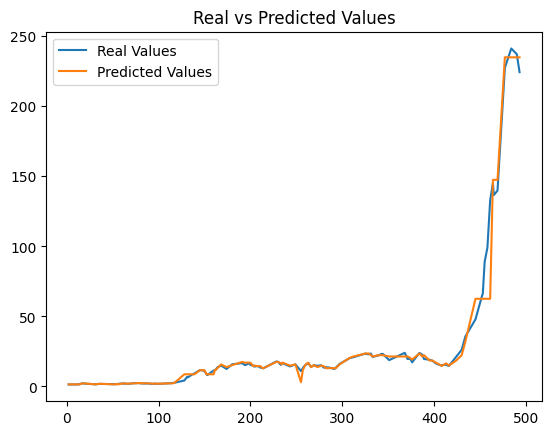

In [289]:
# Create plot to compare real and predicted test stock values

# sort the actual and predicted test data by index 
y_pred_copy = y_test.copy()
for i in range(len(y_pred_copy)):
    y_pred_copy[y_pred_copy.index[i]] = test_pred_cart[i]

plt.title('Real vs Predicted Values')
plt.plot(y_test.sort_index(),  label= 'Real Values')
plt.plot(y_pred_copy.sort_index(), label = 'Predicted Values')
plt.legend()
plt.show()

## RANDOM FOREST Regression
#### To predict next week's stock price

In [290]:
grid_values = {'max_features': np.linspace(1,5,5, dtype='int32'),
               'min_samples_leaf': [5],
               'n_estimators': [500],
               'random_state': [88]} 

rf2 = RandomForestRegressor() 
cv = KFold(n_splits=5,random_state=333,shuffle=True) 
rf_cv = GridSearchCV(rf2, param_grid=grid_values, scoring='r2', cv=cv,verbose=2)
rf_cv.fit(X_train, y_train)
test_pred_rf, train_pred_rf = rf_cv.predict(X_test), rf_cv.predict(X_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] END max_features=1, min_samples_leaf=5, n_estimators=500, random_state=88; total time=   0.6s
[CV] END max_features=1, min_samples_leaf=5, n_estimators=500, random_state=88; total time=   0.6s
[CV] END max_features=1, min_samples_leaf=5, n_estimators=500, random_state=88; total time=   0.6s
[CV] END max_features=1, min_samples_leaf=5, n_estimators=500, random_state=88; total time=   0.6s
[CV] END max_features=1, min_samples_leaf=5, n_estimators=500, random_state=88; total time=   0.6s
[CV] END max_features=2, min_samples_leaf=5, n_estimators=500, random_state=88; total time=   0.6s
[CV] END max_features=2, min_samples_leaf=5, n_estimators=500, random_state=88; total time=   0.6s
[CV] END max_features=2, min_samples_leaf=5, n_estimators=500, random_state=88; total time=   0.6s
[CV] END max_features=2, min_samples_leaf=5, n_estimators=500, random_state=88; total time=   0.6s
[CV] END max_features=2, min_samples_leaf=5, n_es

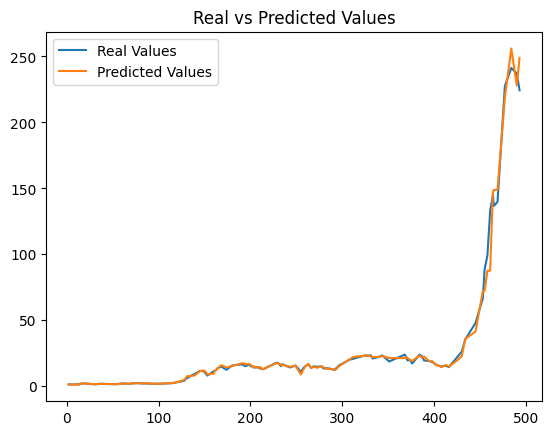

In [291]:
# Create plot to compare real and predicted test stock values

# sort the actual and predicted test data by index 
y_pred_copy = y_test.copy()
for i in range(len(y_pred_copy)):
    y_pred_copy[y_pred_copy.index[i]] = test_pred_rf[i]

plt.title('Real vs Predicted Values')
plt.plot(y_test.sort_index(),  label= 'Real Values')
plt.plot(y_pred_copy.sort_index(), label = 'Predicted Values')
plt.legend()
plt.show()

## GRADIENT BOOSTING Regression
#### To predict next week's stock price

In [292]:
reg = GradientBoostingRegressor(random_state=99)
reg.fit(X_train, y_train)
test_pred_reg, train_pred_reg = reg.predict(X_test), reg.predict(X_train)

In [293]:
feature_comparison = {'Toyota Stock Price': ['{:.3f}'.format(reg.feature_importances_[0])],
                    'Previous Sentiment': ['{:.3f}'.format(reg.feature_importances_[1])],
                   'Previous Week Tesla Stock Price': ['{:.3f}'.format(reg.feature_importances_[2])]}

feature_comparison_table = pd.DataFrame(data=feature_comparison, index=['Feature Importance'])
feature_comparison_table

,Toyota Stock Price,Previous Sentiment,Previous Week Tesla Stock Price
Feature Importance,0.005,0.001,0.994


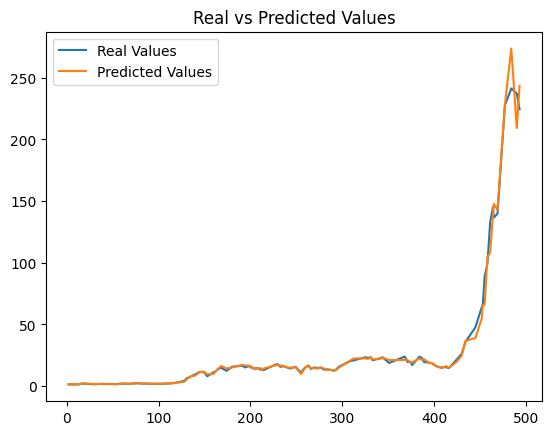

In [294]:
# Create plot to compare real and predicted test stock values

# sort the actual and predicted test data by index 
y_pred_copy = y_test.copy()
for i in range(len(y_pred_copy)):
    y_pred_copy[y_pred_copy.index[i]] = test_pred_reg[i]

plt.title('Real vs Predicted Values')
plt.plot(y_test.sort_index(),  label= 'Real Values')
plt.plot(y_pred_copy.sort_index(), label = 'Predicted Values')
plt.legend()
plt.show()

## Ensemble Model Blending for regression

In [295]:
train = pd.DataFrame({'Tesla_Stock_Price': y_train, 'val_pred_cart': train_pred_cart, 'val_pred_rf': train_pred_rf, 'val_pred_reg': train_pred_reg})
test = pd.DataFrame({'Tesla_Stock_Price': y_test, 'val_pred_cart': test_pred_cart, 'val_pred_rf': test_pred_rf, 'val_pred_reg': test_pred_reg})
ensemble_model = smf.ols(formula='Tesla_Stock_Price ~ val_pred_cart+val_pred_reg+val_pred_rf -1', data=train).fit()
test_pred_ens, train_pred_ens = ensemble_model.predict(test), ensemble_model.predict(train)

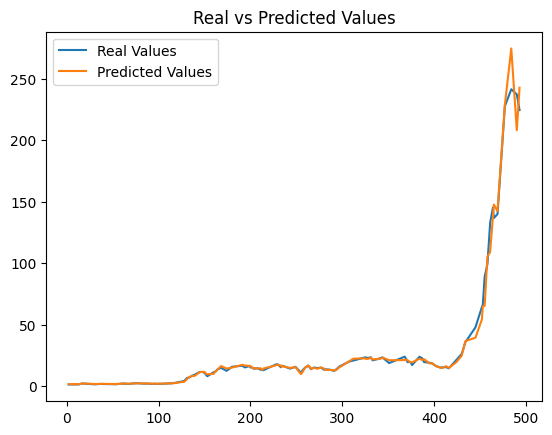

In [296]:
# Create plot to compare real and predicted test stock values

y_pred_copy = test['Tesla_Stock_Price'].copy()
for i in y_pred_copy.index:
    y_pred_copy[i] = test_pred_ens[i]

plt.title('Real vs Predicted Values')
plt.plot(y_test.sort_index(),  label= 'Real Values')
plt.plot(y_pred_copy.sort_index(), label = 'Predicted Values')
plt.legend()
plt.show()

## Regression Model Comparison

In [297]:
comparison_data = {'Linear Regressor': ['{:.3f}'.format(OSR2(lrm, y_train, sm.add_constant(X_test), y_test)),
                                               '{:.4f}'.format(avg_error(lrm.predict(sm.add_constant(X_test)), y_test))],
                    'Decision Tree Regressor': ['{:.3f}'.format(OSR2(dtr_cv, y_train, X_test, y_test)),
                                               '{:.4f}'.format(avg_error(dtr_cv.predict(X_test), y_test))],
                   'Random Forest': ['{:.3f}'.format(OSR2(rf_cv, y_train, X_test, y_test)),
                                     '{:.4f}'.format(avg_error(rf_cv.predict(X_test), y_test))], 
                   'Gradient Boosted Trees': ['{:.3f}'.format(OSR2(reg, y_train, X_test, y_test)),
                                              '{:.4f}'.format(avg_error(reg.predict(X_test), y_test))],
                  'Ensemble Model': ['{:.3f}'.format(OSR2(ensemble_model, y_train, test, y_test)),
                                              '{:.4f}'.format(avg_error(ensemble_model.predict(test), y_test))]}

comparison_table = pd.DataFrame(data=comparison_data, index=['OSR2', 'Average Percent Test Error'])
comparison_table

,Linear Regressor,Decision Tree Regressor,Random Forest,Gradient Boosted Trees,Ensemble Model
OSR2,0.988,0.971,0.985,0.986,0.985
Average Percent Test Error,0.0573,0.0788,0.0581,0.0616,0.0628


In [300]:
var_comparison_data = {'Linear Regressor': ['{:.6f}'.format(variance_mae_percentage)],
                    'Decision Tree Regressor': ['{:.6f}'.format(np.var(bootstrap(X_test, y_test, dtr_cv, avg_error)))],
                   'Random Forest': ['{:.6f}'.format(np.var(bootstrap(X_test, y_test, rf_cv, avg_error)))], 
                   'Gradient Boosted Trees': ['{:.6f}'.format(np.var(bootstrap(X_test, y_test, reg, avg_error)))],
                  'Ensemble Model': ['{:.6f}'.format(np.var(bootstrap(test, y_test, ensemble_model, avg_error)))]}

var_comparison_table = pd.DataFrame(data=var_comparison_data, index=['Variance of Average Percent Test Error'])
var_comparison_table

,Linear Regressor,Decision Tree Regressor,Random Forest,Gradient Boosted Trees,Ensemble Model
Variance of Average Percent Test Error,0.000098,0.000127,0.000022,0.000022,0.000021


## Assemble training & test sets for classification models

#### Create variable "change", representing whether the stock has increased (1) or decreased (0) in the past week

In [264]:
tesla_data = pd.read_csv('../full-tesla-data.csv')
tesla_data.drop(columns=['Unnamed: 0'], inplace=True)
tesla_data['Previous Sentiment'] = tesla_data['Sentiment'].shift(1)
price = tesla_data['Tesla Stock Close Price']

change = [0]
for i in range(1, len(tesla_data)):
    change.append(price[i] > price[i-1])
change = pd.Series([int(val) for val in change])

tesla_data = tesla_data[1:]
tesla_data['change'] = change
train_tesla_data, test_tesla_data = train_test_split(tesla_data)
train_tesla_data

,Tesla Stock Close Price,Tesla Stock Open Price,Tesla Stock Volume,Tesla Stock Adj Close Price,Tesla Stock High,Tesla Stock Low,S&P 500 Variance,Ford Stock Price,GM Stock Price,Toyota Stock Price,Nissan Stock Price,Tesla Wikipedia Page Views,Sentiment,Previous Sentiment,Previous Week Tesla Stock Close Price,change
124,2.808667,2.823733,53376600,2.808667,2.876933,2.753867,64.681671,12.712000,27.716000,104.333998,19.516000,4163.000000,0.160678,0.238354,2.524000,1
41,1.861733,1.866667,24457500,1.861733,1.914400,1.838267,451.490079,13.484000,28.972001,80.900000,19.546000,818.200000,0.113475,0.104897,1.950000,0
153,8.079067,8.192400,183008700,8.079067,8.314000,7.915200,210.486208,16.966000,37.731999,125.700000,18.346000,4508.200000,0.196260,-0.138225,8.948400,0
496,208.355555,206.255559,77746900,208.355555,210.321106,204.454447,1446.851184,14.436666,59.053335,165.183334,9.963333,3498.666667,0.229309,0.196035,194.362003,1
352,18.826266,18.256000,262489500,18.826266,19.167867,17.797066,4122.546708,11.174000,37.281999,127.094002,20.718000,4993.800000,-0.087034,-0.009525,18.784134,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,2.907867,2.849333,40739100,2.907867,2.955200,2.824400,120.214921,13.254000,29.218000,111.751999,20.550000,2589.600000,0.210979,0.160678,2.808667,1
344,23.223466,23.000000,73248000,23.223466,23.452933,22.799733,2672.227091,11.144000,42.810001,139.085998,21.684000,3916.200000,0.086098,0.058261,23.264400,0
270,14.452400,14.540800,48703800,14.452400,14.772000,14.310933,590.681070,13.042000,29.004000,102.096001,18.924000,3035.353026,0.117714,0.057867,15.155867,0
454,66.609734,65.582267,165041700,66.609734,67.727335,63.965468,3725.043749,5.996000,25.114000,126.850000,7.524000,3080.400000,0.201411,0.185949,66.308000,1


In [265]:
X_train = train_tesla_data.drop(columns=['Tesla Stock Close Price', 'change'])
y_train_class = train_tesla_data['change']

X_test = test_tesla_data.drop(columns=['Tesla Stock Close Price', 'change'])
y_test_class = test_tesla_data['change']

features =X_train.columns

## Baseline (predict all weeks stock increase)
#### To predict whether the price increases or decreases next week

In [266]:
def base(data):
    return pd.Series([1] * len(data))

test_pred_base, train_pred_base = base(X_test), base(X_train)
acc_base, TPR_base, FPR_base, PRE_base = get_metrics(test_pred_base, y_test_class)

## CART Classification
#### To predict whether the price increases or decreases next week

In [268]:
grid_values = {'ccp_alpha': np.linspace(0, 0.001, 51)}

dtc = DecisionTreeClassifier(min_samples_leaf=5, min_samples_split=20, random_state=88)
cv = KFold(n_splits=5,random_state=1,shuffle=True) 
dtc_cv = GridSearchCV(dtc, param_grid=grid_values, scoring='r2', cv=cv, verbose=0, error_score='raise')
dtc_cv.fit(X_train, y_train_class)
test_pred_cart, train_pred_cart = dtc_cv.predict(X_test), dtc_cv.predict(X_train)
acc_cart, TPR_cart, FPR_cart, PRE_cart = get_metrics(test_pred_cart, y_test_class)

bs = bootstrap(X_test, y_test_class, dtc_cv, get_metrics)
acc_cart_var, TPR_cart_var, FPR_cart_var, PRE_cart_var = np.var([s[0] for s in bs]), np.var([s[1] for s in bs]), np.var([s[2] for s in bs]), np.var([s[3] for s in bs])

## Random Forest Classification
#### To predict whether the price increases or decreases next week

In [269]:
grid_values = {'min_samples_leaf': [1, 5],
               'n_estimators': [100, 500],
               'random_state': [88]} 

rf2 = RandomForestClassifier() 
cv = KFold(n_splits=5,random_state=333,shuffle=True) 
rf_cv = GridSearchCV(rf2, param_grid=grid_values, scoring='r2', cv=cv,verbose=2)
rf_cv.fit(X_train, y_train_class)
test_pred_rf, train_pred_rf = rf_cv.predict(X_test), rf_cv.predict(X_train)
acc_rf, TPR_rf, FPR_rf, PRE_rf = get_metrics(test_pred_rf, y_test_class)

bs = bootstrap(X_test, y_test_class, rf_cv, get_metrics)
acc_rf_var, TPR_rf_var, FPR_rf_var, PRE_rf_var = np.var([s[0] for s in bs]), np.var([s[1] for s in bs]), np.var([s[2] for s in bs]), np.var([s[3] for s in bs])

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END min_samples_leaf=1, n_estimators=100, random_state=88; total time=   0.2s
[CV] END min_samples_leaf=1, n_estimators=100, random_state=88; total time=   0.2s
[CV] END min_samples_leaf=1, n_estimators=100, random_state=88; total time=   0.2s
[CV] END min_samples_leaf=1, n_estimators=100, random_state=88; total time=   0.2s
[CV] END min_samples_leaf=1, n_estimators=100, random_state=88; total time=   0.2s
[CV] END min_samples_leaf=1, n_estimators=500, random_state=88; total time=   0.8s
[CV] END min_samples_leaf=1, n_estimators=500, random_state=88; total time=   0.8s
[CV] END min_samples_leaf=1, n_estimators=500, random_state=88; total time=   0.8s
[CV] END min_samples_leaf=1, n_estimators=500, random_state=88; total time=   0.8s
[CV] END min_samples_leaf=1, n_estimators=500, random_state=88; total time=   0.8s
[CV] END min_samples_leaf=5, n_estimators=100, random_state=88; total time=   0.2s
[CV] END min_samples_leaf=5

## Gradient Boosting Classifier
#### To predict whether the price increases or decreases next week

In [270]:
reg = GradientBoostingClassifier(random_state=99)
reg.fit(X_train, y_train_class)
test_pred_reg, train_pred_reg = reg.predict(X_test), reg.predict(X_train)
acc_reg, TPR_reg, FPR_reg, PRE_reg = get_metrics(test_pred_reg, y_test_class)

bs = bootstrap(X_test, y_test_class, reg, get_metrics)
acc_reg_var, TPR_reg_var, FPR_reg_var, PRE_reg_var = np.var([s[0] for s in bs]), np.var([s[1] for s in bs]), np.var([s[2] for s in bs]), np.var([s[3] for s in bs])

## Classification Model Comparison

In [271]:
comparison_data = {'Baseline': ['{:.3f}'.format(acc_base),'{:.4f}'.format(TPR_base), '{:.3f}'.format(FPR_base), '{:.3f}'.format(PRE_base)],
                    'Decision Tree Classifier': ['{:.3f}'.format(acc_cart),'{:.4f}'.format(TPR_cart), '{:.3f}'.format(FPR_cart), '{:.3f}'.format(PRE_cart)],
                   'Random Forest Classifier': ['{:.3f}'.format(acc_rf),'{:.4f}'.format(TPR_rf), '{:.3f}'.format(FPR_rf), '{:.3f}'.format(PRE_rf)], 
                   'Gradient Boosted Classifier': ['{:.3f}'.format(acc_reg),'{:.4f}'.format(TPR_reg), '{:.3f}'.format(FPR_reg), '{:.3f}'.format(PRE_reg)]}

comparison_table = pd.DataFrame(data=comparison_data, index=['Accuracy', 'TPR', 'FPR', 'Precision'])
comparison_table

,Baseline,Decision Tree Classifier,Random Forest Classifier,Gradient Boosted Classifier
Accuracy,0.581,0.468,0.702,0.726
TPR,1.0000,0.4583,0.7778,0.8194
FPR,1.000,0.519,0.404,0.404
Precision,0.581,0.550,0.727,0.738


In [272]:
var_comparison_data = {'Decision Tree Classifier': ['{:.3f}'.format(acc_cart_var),'{:.4f}'.format(TPR_cart_var), '{:.3f}'.format(FPR_cart_var), '{:.3f}'.format(PRE_cart_var)],
                   'Random Forest Classifier': ['{:.3f}'.format(acc_rf_var),'{:.4f}'.format(TPR_rf_var), '{:.3f}'.format(FPR_rf_var), '{:.3f}'.format(PRE_rf_var)], 
                   'Gradient Boosted Classifier': ['{:.3f}'.format(acc_reg_var),'{:.4f}'.format(TPR_reg_var), '{:.3f}'.format(FPR_reg_var), '{:.3f}'.format(PRE_reg_var)]}

var_comparison_table = pd.DataFrame(data=var_comparison_data, index=['Variance Accuracy', 'Variance TPR', 'Variance FPR', 'Variance Precision'])
var_comparison_table

,Decision Tree Classifier,Random Forest Classifier,Gradient Boosted Classifier
Variance Accuracy,0.002,0.002,0.002
Variance TPR,0.0035,0.0025,0.0020
Variance FPR,0.005,0.005,0.005
Variance Precision,0.004,0.003,0.003
